In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import collections
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init, image
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

# 14. Natural Language Processing: Pretraining
Humans need to communicate. Out of this basic need of the human condition, a vast amount of written text has been generated on an everyday basis. Given rich text in social media, chat apps, emails, product reviews, news articles, research papers, and books, it becomes vital to enable computers to understand them to offer assistance or make decisions based on human languages.

Natural language processing studies interactions between computers and humans using natural languages. In practice, it is very common to use natural language processing techniques to process and analyze text (human natural language) data, such as language models in `Section 8.3` and machine translation models in `Section 9.5`.

To understand text, we can begin with its representation, such as treating each word or subword as an individual text token. As we will see in this chapter, the representation of each token can be pretrained on a large corpus, using `word2vec`, `GloVe`, or `subword embedding` models. After pretraining, representation of each token can be a vector, however, it remains the same no matter what the context is. For instance, the vector representation of "bank" is the same in both "go to the bank to deposit some money" and "go to the bank to sit down". Thus, many more recent pretraining models adapt representation of the same token to different contexts. Among them is `BERT`, a much deeper model based on the `Transformer` encoder. In this chapter, we will focus on how to pretrain such representations for text, as highlighted in `Fig. 14.1`.

<img src="images/14_01.png" style="width:600px;"/>

As shown in `Fig. 14.1`, the pretrained text representations can be fed to a variety of deep learning architectures for different downstream natural language processing applications. We will cover them in `Chapter 15`.

## 14.1 Word Embedding (word2vec)
A natural language is a complex system that we use to express meanings. In this system, words are the basic unit of linguistic meaning. As its name implies, a word vector is a vector used to represent a word. It can also be thought of as the feature vector of a word. The technique of mapping words to vectors of real numbers is also known as `word embedding`. Over the last few years, word embedding has gradually become basic knowledge in natural language processing.

### 14.1.1 Why Not Use One-hot Vectors?
We used one-hot vectors to represent words (characters are words) in `Section 8.5`. Recall that when we assume the number of different words in a dictionary (the dictionary size) is $N$, each word can correspond one-to-one with consecutive integers from 0 to $N-1$. These integers that correspond to words are called the indices of the words. We assume that the index of a word is $i$. In order to get the one-hot vector representation of the word, we create a vector of all `0`s with a length of $N$ and set element $i$ to 1. In this way, each word is represented as a vector of length $N$ that can be used directly by the neural network.

Although one-hot word vectors are easy to construct, they are usually not a good choice. One of the major reasons is that the one-hot word vectors cannot accurately express the similarity between different words, such as the cosine similarity that we commonly use. For the vectors $\mathbf{x}, \mathbf{y} \in \mathbb{R}^d$, their cosine similarities are the cosines of the angles between them:

$$\displaystyle\frac{\mathbf{x}^\top \mathbf{y}}{\lVert\mathbf{x}\rVert \lVert\mathbf{y}\rVert} \in [-1, 1].$$

Since the cosine similarity between the one-hot vectors of any two different words is 0, it is difficult to use the one-hot vector to accurately represent the similarity between multiple different words.

`Word2vec` is a tool that we came up with to solve the problem above. It represents each word with a fixed-length vector and uses these vectors to better indicate the similarity and analogy relationships between different words. The Word2vec tool contains two models:
+ **skip-gram** (`Mikolov et al., 2013b`) 
+ **continuous bag of words** (CBOW) (`Mikolov et al., 2013a`)

Next, we will take a look at the two models and their training methods.

### 14.1.2 The Skip-Gram Model
The skip-gram model assumes that a word can be used to generate the words that surround it in a text sequence. For example, we assume that the text sequence is `the`, `man`, `loves`, `his`, and `son`. We use `loves` as the central target word and set the context window size to 2. As shown in `Fig. 14.1.1`, given the central target word `loves`, the skip-gram model is concerned with the conditional probability for generating the context words, `the`, `man`, `his` and `son`, that are within a distance of no more than 2 words, which is

$$P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}).$$

We assume that, given the central target word, the context words are generated independently of each other. In this case, the formula above can be rewritten as

$$P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}).$$

<img src="images/14_02.png" style="width:600px;"/>

In the skip-gram model, each word is represented as two $d$-dimension vectors, which are used to compute the conditional probability. We assume that the word is indexed as $i$ in the dictionary, its vector is represented as $\mathbf{v}_i\in\mathbb{R}^d$ when it is the central target word, and $\mathbf{u}_i\in\mathbb{R}^d$ when it is a context word. Let the central target word $w_c$ and context word $w_o$ be indexed as $c$ and $o$ respectively in the dictionary. The conditional probability of generating the context word for the given central target word can be obtained by performing a softmax operation on the vector inner product:

$$P(w_o \mid w_c) = \displaystyle\frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{\displaystyle\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)},$$

where vocabulary index set $\mathcal{V} = {0, 1, \ldots, |\mathcal{V}|-1}$. Assume that a text sequence of length $T$ is given, where the word at timestep $t$ is denoted as $w^{(t)}$. Assume that context words are independently generated given center words. When context window size is $m$, the likelihood function of the skip-gram model is the joint probability of generating all the context words given any center word

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$

Here, any timestep that is less than 1 or greater than $T$ can be ignored.

##### Skip-Gram Model Training
The skip-gram model parameters are the central target word vector and context word vector for each individual word. In the training process, we are going to learn the model parameters by maximizing the likelihood function, which is also known as maximum likelihood estimation. This is equivalent to minimizing the following loss function:

$$ - \sum_{t=1}^{T} \sum_{-m \leq j \leq m,\ j \neq 0} \log{P(w^{(t+j)} \mid w^{(t)}}).$$

If we use the SGD, in each iteration we are going to pick a shorter subsequence through random sampling to compute the loss for that subsequence, and then compute the gradient to update the model parameters. The key of gradient computation is to compute the gradient of the logarithmic conditional probability for the central word vector and the context word vector. By definition, we first have

$$\log P(w_o \mid w_c) = \mathbf{u}_o^\top \mathbf{v}_c - \log\left(\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)\right).$$

Through differentiation, we can get the gradient $\mathbf{v}_c$ from the formula above.

$$ \begin{aligned} \frac{\partial \text{log} P(w_o \mid w_c)}{\partial \mathbf{v}_c} &= \mathbf{u}_o - \frac{\displaystyle\sum_{j \in \mathcal{V}} \exp(\mathbf{u}_j^\top \mathbf{v}_c)\mathbf{u}_j}{\displaystyle\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)} \\ &= \mathbf{u}_o - \displaystyle\sum_{j \in \mathcal{V}} \left(\frac{\text{exp}(\mathbf{u}_j^\top \mathbf{v}_c)}{\displaystyle\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)}\right) \mathbf{u}_j \\ &= \mathbf{u}o - \displaystyle\sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j. \end{aligned} $$

Its computation obtains the conditional probability for all the words in the dictionary given the central target word $w_c$. We then use the same method to obtain the gradients for other word vectors.

After the training, for any word in the dictionary with index $i$, we are going to get its two word vector sets $\mathbf{v}_i$ and $\mathbf{u}_i$. In applications of natural language processing, the central target word vector in the skip-gram model is generally used as the representation vector of a word.

### 14.1.3 The Continuous Bag of Words (CBOW) Model
The continuous bag of words (CBOW) model is similar to the skip-gram model. The biggest difference is that the CBOW model assumes that the central target word is generated based on the context words before and after it in the text sequence. With the same text sequence `the`, `man`, `loves`, `his` and `son`, in which `loves` is the central target word, given a context window size of 2, the CBOW model is concerned with the conditional probability of generating the target word `loves` based on the context words `the`, `man`, `his` and `son` (as shown in `Fig. 14.1.2`), such as

$$P(\textrm{"loves"}\mid\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}).$$

<img src="images/14_03.png" style="width:600px;"/>

Since there are multiple context words in the CBOW model, we will average their word vectors and then use the same method as the skip-gram model to compute the conditional probability. We assume that $\mathbf{v_i}\in\mathbb{R}^d$ and $\mathbf{u_i}\in\mathbb{R}^d$ are the context word vector and central target word vector of the word with index $i$ in the dictionary (notice that the symbols are opposite to the ones in the skip-gram model). Let central target word $w_c$ be indexed as $c$, and context words $w_{o_1}, \ldots, w_{o_{2m}}$ be indexed as $o_1, \ldots, o_{2m}$ in the dictionary. Thus, the conditional probability of generating a central target word from the given context word is

$$P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\text{exp}\left(\frac{1}{2m}\mathbf{u}_c^\top (\mathbf{v}_{o_1} + \ldots, + \mathbf{v}_{o_{2m}}) \right)}{ \sum_{i \in \mathcal{V}} \text{exp}\left(\frac{1}{2m}\mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots, + \mathbf{v}_{o_{2m}}) \right)}.$$

For brevity, denote $\mathcal{W}_o= {w_{o_1}, \ldots, w_{o_{2m}}}$, and $\bar{\mathbf{v}}_o = \left(\mathbf{v}_{o_1} + \ldots, + \mathbf{v}_{o_{2m}} \right)/(2m)$. The equation above can be simplified as

$$P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.$$

Given a text sequence of length $T$, we assume that the word at timestep $t$ is $w^{(t)}$, and the context window size is $m$. The likelihood function of the CBOW model is the probability of generating any central target word from the context words.

$$ \prod_{t=1}^{T} P(w^{(t)} \mid w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

##### CBOW Model Training
CBOW model training is quite similar to skip-gram model training. The maximum likelihood estimation of the CBOW model is equivalent to minimizing the loss function.

$$ -\sum_{t=1}^T \text{log} P(w^{(t)} \mid w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

Notice that

$$\log P(w_c \mid \mathcal{W}_o) = \mathbf{u}_c^\top \bar{\mathbf{v}}o - \log,\left(\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)\right).$$

Through differentiation, we can compute the logarithm of the conditional probability of the gradient of any context word vector $\mathbf{v}_{o_i}$($i = 1, \ldots, 2m$) in the formula above.

$$\frac{\partial \log P(w_c \mid \mathcal{W}o)}{\partial \mathbf{v}{o_i}} = \frac{1}{2m} \left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} \frac{\exp(\mathbf{u}_j^\top \bar{\mathbf{v}}_o)\mathbf{u}_j}{\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \bar{\mathbf{v}}_o)} \right) = \frac{1}{2m}\left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} P(w_j \mid \mathcal{W}_o) \mathbf{u}_j \right).$$

We then use the same method to obtain the gradients for other word vectors. Unlike the skip-gram model, we usually use the context word vector as the representation vector for a word in the CBOW model.

##### Summary
+ A word vector is a vector used to represent a word. The technique of mapping words to vectors of real numbers is also known as word embedding.
+ Word2vec includes both the continuous bag of words (CBOW) and skip-gram models. The skip-gram model assumes that context words are generated based on the central target word. The CBOW model assumes that the central target word is generated based on the context words.

##### Exercises
1. What is the computational complexity of each gradient? If the dictionary contains a large volume of words, what problems will this cause?
2. There are some fixed phrases in the English language which consist of multiple words, such as "new york". How can you train their word vectors? Hint: See section 4 in the Word2vec paper[2].
3. Use the skip-gram model as an example to think about the design of a word2vec model. What is the relationship between the inner product of two word vectors and the cosine similarity in the skip-gram model? For a pair of words with close semantical meaning, why it is likely for their word vector cosine similarity to be high?

## 14.2 Approximate Training
Recall content of the last section. The core feature of the skip-gram model is the use of softmax operations to compute the conditional probability of generating context word $w_o$ based on the given central target word $w_c$.

$$P(w_o \mid w_c) = \frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{\displaystyle\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)}.$$

The logarithmic loss corresponding to the conditional probability is given as

$$-\log P(w_o \mid w_c) =
-\mathbf{u}_o^\top \mathbf{v}_c + \log\left(\displaystyle\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)\right).$$

Because the softmax operation has considered that the context word could be any word in the dictionary $\mathcal{V}$, the loss mentioned above actually includes the sum of the number of items in the dictionary size. From the last section, we know that for both the skip-gram model and CBOW model, because they both get the conditional probability using a softmax operation, the gradient computation for each step contains the sum of the number of items in the dictionary size. For larger dictionaries with hundreds of thousands or even millions of words, the overhead for computing each gradient may be too high.  In order to reduce such computational complexity, we will introduce two approximate training methods in this section: negative sampling and hierarchical softmax. Since there is no major difference between the skip-gram model and the CBOW model, we will only use the skip-gram model as an example to introduce these two training methods in this section.

### 14.2.1 Negative Sampling
Negative sampling modifies the original objective function. Given a context window for the central target word $w_c$, we will treat it as an event for context word $w_o$ to appear in the context window and compute the probability of this event from

$$P(D=1\mid w_c, w_o) = \sigma(\mathbf{u}_o^\top \mathbf{v}_c),$$

Here, the $\sigma$ function has the same definition as the sigmoid activation function:

$$\sigma(x) = \frac{1}{1+\exp(-x)}.$$

We will first consider training the word vector by maximizing the joint probability of all events in the text sequence. Given a text sequence of length $T$, we assume that the word at timestep $t$ is $w^{(t)}$ and the context window size is $m$. Now we consider maximizing the joint probability

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(D=1\mid w^{(t)}, w^{(t+j)}).$$

However, the events included in the model only consider positive examples. In this case, only when all the word vectors are equal and their values approach infinity can the joint probability above be maximized to 1. Obviously, such word vectors are meaningless. Negative sampling makes the objective function more meaningful by sampling with an addition of negative examples. Assume that event $P$ occurs when context word $w_o$ appears in the context window of central target word $w_c$, and we sample $K$ words that do not appear in the context window according to the distribution $P(w)$ to act as noise words. We assume the event for noise word $w_k$($k=1, \ldots, K$) to not appear in the context window of central target word $w_c$ is $N_k$. Suppose that events $P$ and $N_1, \ldots, N_K$ for both positive and negative examples are independent of each other. By considering negative sampling, we can rewrite the joint probability above, which only considers the positive examples, as

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$

Here, the conditional probability is approximated to be
$$ P(w^{(t+j)} \mid w^{(t)}) =P(D=1\mid w^{(t)}, w^{(t+j)})\prod_{k=1,\ w_k \sim P(w)}^K P(D=0\mid w^{(t)}, w_k).$$


Let the text sequence index of word $w^{(t)}$ at timestep $t$ be $i_t$ and $h_k$ for noise word $w_k$ in the dictionary. The logarithmic loss for the conditional probability above is

$$
\begin{aligned}
-\log P(w^{(t+j)} \mid w^{(t)})
=& -\log P(D=1\mid w^{(t)}, w^{(t+j)}) - \sum_{k=1,\ w_k \sim P(w)}^K \log P(D=0\mid w^{(t)}, w_k)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\left(1-\sigma\left(\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right)\right)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\sigma\left(-\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right).
\end{aligned}
$$

Here, the gradient computation in each step of the training is no longer related to the dictionary size, but linearly related to $K$. When $K$ takes a smaller constant, the negative sampling has a lower computational overhead for each step.

### 14.2.1 Hierarchical Softmax
Hierarchical softmax is another type of approximate training method. It uses a binary tree for data structure as illustrated in `Fig. 14.2.1`, with the leaf nodes of the tree representing every word in the dictionary $\mathcal{V}$.

<img src="images/14_04.png" style="width:500px;"/>

We assume that $L(w)$ is the number of nodes on the path (including the root and leaf nodes) from the root node of the binary tree to the leaf node of word $w$. Let $n(w, j)$ be the $j^\mathrm{th}$ node on this path, with the context word vector $\mathbf{u}_{n(w, j)}$. We use Figure 10.3 as an example, so $L(w_3) = 4$. Hierarchical softmax will approximate the conditional probability in the skip-gram model as

$$P(w_o \mid w_c) = \prod_{j=1}^{L(w_o)-1} \sigma\left( [\![  n(w_o, j+1) = \text{leftChild}(n(w_o, j)) ]\!] \cdot \mathbf{u}_{n(w_o, j)}^\top \mathbf{v}_c\right),$$

Here the $\sigma$ function has the same definition as the sigmoid activation function, and $\text{leftChild}(n)$ is the left child node of node $n$. If $x$ is true, $[\![x]\!] = 1$; otherwise $[\![x]\!] = -1$.
Now, we will compute the conditional probability of generating word $w_3$ based on the given word $w_c$ in Figure 10.3. We need to find the inner product of word vector $\mathbf{v}_c$ (for word $w_c$) and each non-leaf node vector on the path from the root node to $w_3$. Because, in the binary tree, the path from the root node to leaf node $w_3$ needs to be traversed left, right, and left again (the path with the bold line in Figure 10.3), we get

$$P(w_3 \mid w_c) = \sigma(\mathbf{u}_{n(w_3, 1)}^\top \mathbf{v}_c) \cdot \sigma(-\mathbf{u}_{n(w_3, 2)}^\top \mathbf{v}_c) \cdot \sigma(\mathbf{u}_{n(w_3, 3)}^\top \mathbf{v}_c).$$

Because $\sigma(x)+\sigma(-x) = 1$, the condition that the sum of the conditional probability of any word generated based on the given central target word $w_c$ in dictionary $\mathcal{V}$ be 1 will also suffice:

$$\sum_{w \in \mathcal{V}} P(w \mid w_c) = 1.$$

In addition, because the order of magnitude for $L(w_o)-1$ is $\mathcal{O}(\text{log}_2|\mathcal{V}|)$, when the size of dictionary $\mathcal{V}$ is large, the computational overhead for each step in the hierarchical softmax training is greatly reduced compared to situations where we do not use approximate training.

##### Summary
* Negative sampling constructs the loss function by considering independent events that contain both positive and negative examples. The gradient computational overhead for each step in the training process is linearly related to the number of noise words we sample.
* Hierarchical softmax uses a binary tree and constructs the loss function based on the path from the root node to the leaf node. The gradient computational overhead for each step in the training process is related to the logarithm of the dictionary size.

##### Exercises
1. Before reading the next section, think about how we should sample noise words in negative sampling.
2. What makes the last formula in this section hold?
3. How can we apply negative sampling and hierarchical softmax in the skip-gram model?

## 14.3 The Dataset for Pretraining Word Embedding
In this section, we will introduce how to preprocess a dataset with negative sampling `Section 14.2` and load into minibatches for word2vec training. The dataset we use is [Penn Tree Bank (PTB)](https://catalog.ldc.upenn.edu/LDC99T42), which is a small but commonly-used corpus. It takes samples from Wall Street Journal articles and includes training sets, validation sets, and test sets.

### 14.3.1 Reading and Preprocessing the Dataset
This dataset has already been preprocessed. Each line of the dataset acts as a sentence. All the words in a sentence are separated by spaces. In the word embedding task, each word is a token.

In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    data_dir = d2l.download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

Next we build a vocabulary with words appeared not greater than 10 times mapped into a `<unk>` token. Note that the preprocessed PTB data also contains `<unk>` tokens presenting rare words.

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}' 

'vocab size: 6719'

### 14.3.2 Subsampling
In text data, there are generally some words that appear at high frequencies, such `the`, `a`, and `in` in English. Generally speaking, in a context window, it is better to train the word embedding model when a word (such as "chip") and a lower-frequency word (such as "microprocessor") appear at the same time, rather than when a word appears with a higher-frequency word (such as "the"). Therefore, when training the word embedding model, we can perform subsampling[2] on the words. Specifically, each indexed word $w_i$ in the dataset will drop out at a certain probability. The dropout probability is given as:

$$ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

Here, $f(w_i)$ is the ratio of the instances of word $w_i$ to the total number of words in the dataset, and the constant $t$ is a hyperparameter (set to $10^{-4}$ in this experiment). As we can see, it is only possible to drop out the word $w_i$ in subsampling when $f(w_i) > t$. The higher the word's frequency, the higher its dropout probability.

In [4]:
#@save
def subsampling(sentences, vocab):
    # Map low frequency words into <unk>
    sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line] for line in sentences]
    # Count the frequency for each word
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # Return True if to keep this token during subsampling
    def keep(token):
        return(random.uniform(0, 1) < math.sqrt(1e-4/counter[token]*num_tokens))

    # Now do the subsampling
    return [[tk for tk in line if keep(tk)] for line in sentences]

subsampled = subsampling(sentences, vocab)
f'subsampled size: {len(subsampled)}' 

'subsampled size: 42069'

Compare the sequence lengths before and after sampling, we can see subsampling significantly reduced the sequence length.

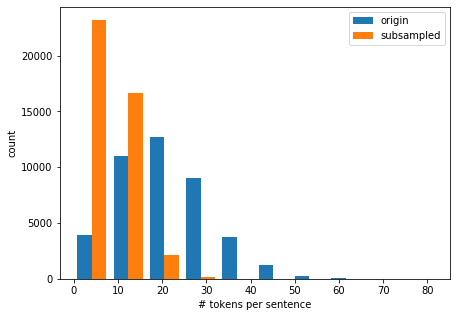

In [5]:
d2l.set_figsize()
d2l.plt.hist([[len(line) for line in sentences],
              [len(line) for line in subsampled]])
d2l.plt.xlabel('# tokens per sentence')
d2l.plt.ylabel('count')
d2l.plt.legend(['origin', 'subsampled']);

For individual tokens, the sampling rate of the high-frequency word `the` is less than 1/20.

In [6]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([line.count(token) for line in sentences])}, '
            f'after={sum([line.count(token) for line in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2170'

But the low-frequency word `join` is completely preserved.

In [7]:
compare_counts('join')

'# of "join": before=45, after=45'

Last, we map each token into an index to construct the corpus.

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[0], [2132, 145, 275], [5464, 3080, 1595]]

### 14.3.3 Loading the Dataset
Next we read the corpus with token indicies into data batches for training.

##### Extracting Central Target Words and Context Words
We use words with a distance from the central target word not exceeding the context window size as the context words of the given center target word. The following definition function extracts all the central target words and their context words. It uniformly and randomly samples an integer to be used as the context window size between integer 1 and the `max_window_size` (maximum context window).

In [9]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a "central target word - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

Next, we create an artificial dataset containing two sentences of 7 and 3 words, respectively. Assume the maximum context window is 2 and print all the central target words and their context words.

In [10]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


We set the maximum context window size to 5. The following extracts all the central target words and their context words in the dataset.

In [11]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {len(all_centers)}' 

'# center-context pairs: 353590'

##### Negative Sampling
We use negative sampling for approximate training. For a central and context word pair, we randomly sample $K$ noise words ($K=5$ in the experiment). According to the suggestion in the Word2vec paper, the noise word sampling probability $P(w)$ is the ratio of the word frequency of $w$ to the total word frequency raised to the power of 0.75.

We first define a class to draw a candidate according to the sampling weights. It caches a 10000 size random number bank instead of calling `random.choices` every time.

In [12]:
#@save
class RandomGenerator:
    """Draw a random int in [0, n] according to n sampling weights."""
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        # print(self.population)
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 从population中进行K次随机选取，每次选取一个元素，同一个元素可能多次被选中
            # weights是相对权重值，population中有几个元素就要有相对应的weights值，cum_weights是累加权重值
            # 一次取k个，返回一个k长的列表
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i-1]

generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[0, 2, 2, 0, 2, 0, 1, 1, 0, 1]

In [13]:
#@save
def get_negatives(all_contexts, corpus, K):
    counter = d2l.count_corpus(corpus)
    sampling_weights = [counter[i]**0.75 for i in range(len(counter))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, corpus, 5)

##### Reading into Batches
We extract all central target words `all_centers`, and the context words `all_contexts` and noise words `all_negatives` of each central target word from the dataset. We will read them in random minibatches.

In a minibatch of data, the $i^\mathrm{th}$ example includes a central word and its corresponding $n_i$ context words and $m_i$ noise words. Since the context window size of each example may be different, the sum of context words and noise words, $n_i+m_i$, will be different. When constructing a minibatch, we concatenate the context words and noise words of each example, and add `0` for padding until the length of the concatenations are the same, that is, the length of all concatenations is $\max_i n_i+m_i$(max_len). In order to avoid the effect of padding on the loss function calculation, we construct the mask variable masks, each element of which corresponds to an element in the concatenation of context and noise words, `contexts_negatives`. When an element in the variable `contexts_negatives` is a padding, the element in the mask variable masks at the same position will be 0. Otherwise, it takes the value 1. In order to distinguish between positive and negative examples, we also need to distinguish the context words from the noise words in the `contexts_negatives` variable. Based on the construction of the mask variable, we only need to create a label variable labels with the same shape as the `contexts_negatives` variable and set the elements corresponding to context words (positive examples) to 1, and the rest to 0.

Next, we will implement the minibatch reading function batchify. Its minibatch input data is a list whose length is the batch size, each element of which contains central target words center, context words context, and noise words negative. The minibatch data returned by this function conforms to the format we need, for example, it includes the mask variable.

In [14]:
#@save
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (np.array(centers).reshape(-1, 1), 
            np.array(contexts_negatives),
            np.array(masks), np.array(labels))

Construct two simple examples:

In [15]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = [[1.]
 [1.]]
contexts_negatives = [[2. 2. 3. 3. 3. 3.]
 [2. 2. 2. 3. 3. 0.]]
masks = [[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0.]]
labels = [[1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]]


We use the `batchify` function just defined to specify the minibatch reading method in the `DataLoader` instance.

### 14.3.4 Putting All Things Together
Last, we define the `load_data_ptb` function that read the `PTB` dataset and return the data iterator.

In [16]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled = subsampling(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, corpus, num_noise_words)
    dataset = gluon.data.ArrayDataset(all_centers, all_contexts, all_negatives)
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True,
                                      batchify_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

Let us print the first minibatch of the data iterator.

In [17]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: (512, 1)
contexts_negatives shape: (512, 60)
masks shape: (512, 60)
labels shape: (512, 60)


##### Summary
+ Subsampling attempts to minimize the impact of high-frequency words on the training of a word embedding model.
+ We can pad examples of different lengths to create minibatches with examples of all the same length and use mask variables to distinguish between padding and non-padding elements, so that only non-padding elements participate in the calculation of the loss function.

##### Exercises
1. We use the batchify function to specify the minibatch reading method in the DataLoader instance and print the shape of each variable in the first batch read. How should these shapes be calculated?


## 14.4 Pretraining word2vec
In this section, we will train a skip-gram model defined in `Section 14.1`.

First, import the packages and modules required for the experiment, and load the `PTB` dataset.

In [18]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

### 14.4.1 The Skip-Gram Model
We will implement the skip-gram model by using embedding layers and minibatch multiplication. These methods are also often used to implement other natural language processing applications.

##### Embedding Layer
The layer in which the obtained word is embedded is called the embedding layer, which can be obtained by creating an `nn.Embedding` instance in `Gluon`. The weight of the embedding layer is a matrix whose number of rows is the dictionary size (`input_dim`) and whose number of columns is the dimension of each word vector (`output_dim`). We set the dictionary size to $20$ and the word vector dimension to $4$.

In [19]:
embed = nn.Embedding(input_dim=20, output_dim=4)
embed.initialize()
embed.weight

Parameter embedding0_weight (shape=(20, 4), dtype=float32)

The input of the embedding layer is the index of the word. When we enter the index $i$ of a word, the embedding layer returns the $i^\mathrm{th}$ row of the weight matrix as its word vector. Below we enter an index of shape ($2$, $3$) into the embedding layer. Because the dimension of the word vector is 4, we obtain a word vector of shape ($2$, $3$, $4$).

In [20]:
x = np.array([[1, 2, 3], [4, 5, 6]])
embed(x)

array([[[ 0.01438687,  0.05011239,  0.00628365,  0.04861524],
        [-0.01068833,  0.01729892,  0.02042518, -0.01618656],
        [-0.00873779, -0.02834515,  0.05484822, -0.06206018]],

       [[ 0.06491279, -0.03182812, -0.01631819, -0.00312688],
        [ 0.0408415 ,  0.04370362,  0.00404529, -0.0028032 ],
        [ 0.00952624, -0.01501013,  0.05958354,  0.04705103]]])

##### Minibatch Multiplication
We can multiply the matrices in two minibatches one by one, by the minibatch multiplication operation batch_dot. Suppose the first batch contains $n$ matrices $\mathbf{X}_1, \ldots, \mathbf{X}_n$ with a shape of $a\times b$, and the second batch contains $n$ matrices $\mathbf{Y}_1, \ldots, \mathbf{Y}_n$ with a shape of $b\times c$. The output of matrix multiplication on these two batches are $n$ matrices $\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$ with a shape of $a\times c$. Therefore, given two tensors of shape ($n$, $a$, $b$) and ($n$, $b$, $c$), the shape of the minibatch multiplication output is ($n$, $a$, $c$).

In [21]:
X = np.ones((2, 1, 4))
Y = np.ones((2, 4, 6))
npx.batch_dot(X, Y).shape

(2, 1, 6)

##### Skip-gram Model Forward Calculation
In forward calculation, the input of the skip-gram model contains the central target word index center and the concatenated context and noise word index `contexts_and_negatives`. In which, the center variable has the shape `(batch size, 1)`, while the `contexts_and_negatives` variable has the shape `(batch size, max_len)`. These two variables are first transformed from word indexes to word vectors by the word embedding layer, and then the output of shape `(batch size, 1, max_len)` is obtained by minibatch multiplication. Each element in the output is the inner product of the central target word vector and the context word vector or noise word vector.

In [22]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = npx.batch_dot(v, u.swapaxes(1, 2))
    return pred

Verify that the output shape should be `(batch size, 1, max_len)`.

In [23]:
skip_gram(np.ones((2, 1)), np.ones((2, 4)), embed, embed).shape

(2, 1, 4)

### 14.4.2 Training
Before training the word embedding model, we need to define the loss function of the model.

##### Binary Cross Entropy Loss Function
According to the definition of the loss function in negative sampling, we can directly use `Gluon`'s binary cross-entropy loss function `SigmoidBinaryCrossEntropyLoss`.

In [24]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

It is worth mentioning that we can use the mask variable to specify the partial predicted value and label that participate in loss function calculation in the minibatch: when the mask is 1, the predicted value and label of the corresponding position will participate in the calculation of the loss function; When the mask is 0, the predicted value and label of the corresponding position do not participate in the calculation of the loss function. As we mentioned earlier, mask variables can be used to avoid the effect of padding on loss function calculations.

Given two identical examples, different masks lead to different loss values.

In [25]:
pred = np.array([[.5]*4]*2)
label = np.array([[1, 0, 1, 0]]*2)
mask = np.array([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask)

array([0.724077 , 0.3620385])

We can normalize the loss in each example due to various lengths in each example.

In [26]:
loss(pred, label, mask) / mask.sum(axis=1) * mask.shape[1]

array([0.724077, 0.724077])

##### Initializing Model Parameters
We construct the embedding layers of the central and context words, respectively, and set the hyperparameter word vector dimension `embed_size` to 100.

In [27]:
embed_size = 100
net = nn.Sequential()
net.add(nn.Embedding(input_dim=len(vocab), output_dim=embed_size),
        nn.Embedding(input_dim=len(vocab), output_dim=embed_size))

##### Training
The training function is defined below. Because of the existence of padding, the calculation of the loss function is slightly different compared to the previous training functions.

In [28]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    net.initialize(ctx=device, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of losses, no. of tokens
        for i, batch in enumerate(data_iter):
            center, context_negative, mask, label = [
                data.as_in_ctx(device) for data in batch]
            with autograd.record():
                pred = skip_gram(center, context_negative, net[0], net[1])
                l = (loss(pred.reshape(label.shape), label, mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.backward()
            trainer.step(batch_size)
            metric.add(l.sum(), l.size)
            if (i+1) % 50 == 0:
                animator.add(epoch+(i+1)/len(data_iter),
                             (metric[0]/metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

Now, we can train a skip-gram model using negative sampling.

loss 0.331, 2383.0 tokens/sec on cpu(0)


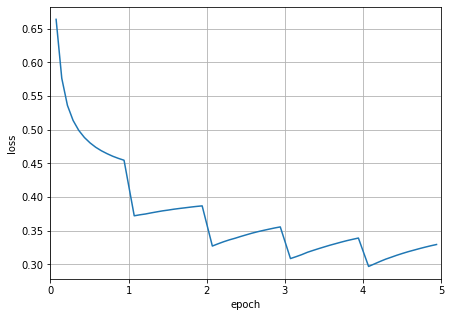

In [29]:
lr, num_epochs = 0.01, 5
train(net, data_iter, lr, num_epochs)

### 14.4.3 Applying the Word Embedding Model
After training the word embedding model, we can represent similarity in meaning between words based on the cosine similarity of two word vectors. As we can see, when using the trained word embedding model, the words closest in meaning to the word `chip` are mostly related to chips.

In [30]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data()
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = np.dot(W, x) / np.sqrt(np.sum(W * W, axis=1) * np.sum(x * x) + 1e-9)
    topk = npx.topk(cos, k=k+1, ret_typ='indices').asnumpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.idx_to_token[i]}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.495: intel
cosine sim=0.453: mips
cosine sim=0.448: computerized


##### Summary
+ We can pretrain a skip-gram model through negative sampling.

##### Exercises
1. Set `sparse_grad=True` when creating an instance of `nn.Embedding`. Does it accelerate training? Look up `MXNet` documentation to learn the meaning of this argument.
2. Try to find synonyms for other words.
3. Tune the hyperparameters and observe and analyze the experimental results.
4. When the dataset is large, we usually sample the context words and the noise words for the central target word in the current minibatch only when updating the model parameters. In other words, the same central target word may have different context words or noise words in different epochs. What are the benefits of this sort of training? Try to implement this training method.


## 14.5 Word Embedding with Global Vectors (GloVe)
First, we should review the skip-gram model in word2vec. The conditional probability $P(w_j\mid w_i)$ expressed in the skip-gram model using the softmax operation will be recorded as $q_{ij}$, that is:

$$q_{ij}=\frac{\exp(\mathbf{u}_j^\top \mathbf{v}_i)}{\displaystyle\sum_{k \in \mathcal{V}} \text{exp}(\mathbf{u}_k^\top \mathbf{v}_i)},$$

where $\mathbf{v}_i$ and $\mathbf{u}_i$ are the vector representations of word $w_i$ of index $i$ as the center word and context word respectively, and $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$ is the vocabulary index set.

For word $w_i$, it may appear in the dataset for multiple times. We collect all the context words every time when $w_i$ is a center word and keep duplicates, denoted as multiset $\mathcal{C}_i$. The number of an element in a multiset is called the multiplicity of the element. For instance, suppose that word $w_i$ appears twice in the dataset: the context windows when these two $w_i$ become center words in the text sequence contain context word indices $2, 1, 5, 2$ and $2, 3, 2, 1$. Then, multiset $\mathcal{C}_i = \{1, 1, 2, 2, 2, 2, 3, 5\}$, where multiplicity of element 1 is 2, multiplicity of element 2 is 4, and multiplicities of elements 3 and 5 are both 1. Denote multiplicity of element $j$ in multiset $\mathcal{C}_i$ as $x_{ij}$: it is the number of word $w_j$ in all the context windows for center word $w_i$ in the entire dataset. As a result, the loss function of the skip-gram model can be expressed in a different way:

$$-\sum_{i\in\mathcal{V}}\sum_{j\in\mathcal{V}} x_{ij} \log\,q_{ij}.$$

We add up the number of all the context words for the central target word $w_i$ to get $x_i$, and record the conditional probability $x_{ij}/x_i$ for generating context word $w_j$ based on central target word $w_i$ as $p_{ij}$. We can rewrite the loss function of the skip-gram model as

$$-\sum_{i\in\mathcal{V}} x_i \sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}.$$

In the formula above, $\displaystyle\sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}$ computes the conditional probability distribution $p_{ij}$ for context word generation based on the central target word $w_i$ and the cross-entropy of conditional probability distribution $q_{ij}$ predicted by the model. The loss function is weighted using the sum of the number of context words with the central target word $w_i$. If we minimize the loss function from the formula above, we will be able to allow the predicted conditional probability distribution to approach as close as possible to the true conditional probability distribution.

However, although the most common type of loss function, the cross-entropy loss function is sometimes not a good choice. On the one hand, as we mentioned in `Section 14.2` the cost of letting the model prediction $q_{ij}$ become the legal probability distribution has the sum of all items in the entire dictionary in its denominator. This can easily lead to excessive computational overhead. On the other hand, there are often a lot of uncommon words in the dictionary, and they appear rarely in the dataset. In the cross-entropy loss function, the final prediction of the conditional probability distribution on a large number of uncommon words is likely to be inaccurate.



### 14.5.1 The GloVe Model
To address this, GloVe (`Pennington et al., 2014`), a word embedding model that came after word2vec, adopts square loss and makes three changes to the skip-gram model based on this loss.

1. Here, we use the non-probability distribution variables $p'_{ij}=x_{ij}$ and $q'_{ij}=\exp(\mathbf{u}_j^\top \mathbf{v}_i)$ and take their logs. Therefore, we get the square loss $\left(\log\,p'_{ij} - \log\,q'_{ij}\right)^2 = \left(\mathbf{u}_j^\top \mathbf{v}_i - \log\,x_{ij}\right)^2$.
2. We add two scalar model parameters for each word $w_i$: the bias terms $b_i$ (for central target words) and $c_i$( for context words).
3. Replace the weight of each loss with the function $h(x_{ij})$. The weight function $h(x)$ is a monotone increasing function with the range $[0, 1]$.

Therefore, the goal of GloVe is to minimize the loss function.

$$\sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}} h(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j - \log\,x_{ij}\right)^2.$$

Here, we have a suggestion for the choice of weight function $h(x)$: when $x < c$ (e.g $c = 100$), make $h(x) = (x/c) ^\alpha$ (e.g $\alpha = 0.75$), otherwise make $h(x) = 1$. Because $h(0)=0$, the squared loss term for $x_{ij}=0$ can be simply ignored. When we use minibatch SGD for training, we conduct random sampling to get a non-zero minibatch $x_{ij}$ from each timestep and compute the gradient to update the model parameters. These non-zero $x_{ij}$ are computed in advance based on the entire dataset and they contain global statistics for the dataset. Therefore, the name GloVe is taken from "Global Vectors".

Notice that if word $w_i$ appears in the context window of word $w_j$, then word $w_j$ will also appear in the context window of word $w_i$. Therefore, $x_{ij}=x_{ji}$. Unlike word2vec, GloVe fits the symmetric $\log\, x_{ij}$ in lieu of the asymmetric conditional probability $p_{ij}$. Therefore, the central target word vector and context word vector of any word are equivalent in GloVe. However, the two sets of word vectors that are learned by the same word may be different in the end due to different initialization values. After learning all the word vectors, GloVe will use the sum of the central target word vector and the context word vector as the final word vector for the word.


### 14.5.2 Understanding GloVe from Conditional Probability Ratios
We can also try to understand GloVe word embedding from another perspective. We will continue the use of symbols from earlier in this section, $P(w_j \mid w_i)$ represents the conditional probability of generating context word $w_j$ with central target word $w_i$ in the dataset, and it will be recorded as $p_{ij}$. From a real example from a large corpus, here we have the following two sets of conditional probabilities with "ice" and "steam" as the central target words and the ratio between them:

<img src="images/t_14_01.png" style="width:500px;"/>

We will be able to observe phenomena such as:
* For a word $w_k$ that is related to "ice" but not to "steam", such as $w_k=$"solid", we would expect a larger conditional probability ratio, like the value 8.9 in the last row of the table above.
* For a word $w_k$ that is related to "steam" but not to "ice", such as $w_k=$"gas", we would expect a smaller conditional probability ratio, like the value 0.085 in the last row of the table above.
* For a word $w_k$ that is related to both "ice" and "steam", such as $w_k=$"water", we would expect a conditional probability ratio close to 1, like the value 1.36 in the last row of the table above.
* For a word $w_k$ that is related to neither "ice" or "steam", such as $w_k=$"fashion", we would expect a conditional probability ratio close to 1, like the value 0.96 in the last row of the table above.

We can see that the conditional probability ratio can represent the relationship between different words more intuitively. We can construct a word vector function to fit the conditional probability ratio more effectively. As we know, to obtain any ratio of this type requires three words $w_i$, $w_j$, and $w_k$. The conditional probability ratio with $w_i$ as the central target word is ${p_{ij}}/{p_{ik}}$. We can find a function that uses word vectors to fit this conditional probability ratio.

$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) \approx \frac{p_{ij}}{p_{ik}}.$$

The possible design of function $f$ here will not be unique. We only need to consider a more reasonable possibility. Notice that the conditional probability ratio is a scalar, we can limit $f$ to be a scalar function: $f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = f\left((\mathbf{u}_j - \mathbf{u}_k)^\top {\mathbf{v}}_i\right)$. After exchanging index $j$ with $k$, we will be able to see that function $f$ satisfies the condition $f(x)f(-x)=1$, so one possibility could be $f(x)=\exp(x)$. Thus:

$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = \frac{\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right)}{\exp\left(\mathbf{u}_k^\top {\mathbf{v}}_i\right)} \approx \frac{p_{ij}}{p_{ik}}.$$

One possibility that satisfies the right side of the approximation sign is $\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right) \approx \alpha p_{ij}$, where $\alpha$ is a constant. Considering that $p_{ij}=x_{ij}/x_i$, after taking the logarithm we get $\mathbf{u}_j^\top {\mathbf{v}}_i \approx \log\,\alpha + \log\,x_{ij} - \log\,x_i$. We use additional bias terms to fit $- \log\, \alpha + \log\, x_i$, such as the central target word bias term $b_i$ and context word bias term $c_j$:

$$\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j \approx \log(x_{ij}).$$

By taking the square error and weighting the left and right sides of the formula above, we can get the loss function of GloVe.


## Summary

* In some cases, the cross-entropy loss function may have a disadvantage. GloVe uses squared loss and the word vector to fit global statistics computed in advance based on the entire dataset.
* The central target word vector and context word vector of any word are equivalent in GloVe.


## Exercises

1. If a word appears in the context window of another word, how can we use the
  distance between them in the text sequence to redesign the method for
  computing the conditional probability $p_{ij}$? Hint: See section 4.2 from the
  paper GloVe :cite:`Pennington.Socher.Manning.2014`.
1. For any word, will its central target word bias term and context word bias term be equivalent to each other in GloVe? Why?

## 14.6 Subword Embedding
English words usually have internal structures and formation methods. For example, we can deduce the relationship between `dog`, `dogs`, and `dogcatcher` by their spelling. All these words have the same root, `dog`, but they use different suffixes to change the meaning of the word. Moreover, this association can be extended to other words. For example, the relationship between `dog` and `dogs` is just like the relationship between `cat` and `cats`. The relationship between `boy` and `boyfriend` is just like the relationship between `girl` and `girlfriend`. This characteristic is not unique to English. In French and Spanish, a lot of verbs can have more than 40 different forms depending on the context. In Finnish, a noun may have more than 15 forms. In fact, morphology, which is an important branch of linguistics, studies the internal structure and formation of words.

### 14.6.1 fastText
In word2vec, we did not directly use morphology information. In both the skip-gram model and continuous bag-of-words model, we use different vectors to represent words with different forms. For example, `dog` and `dogs` are represented by two different vectors, while the relationship between these two vectors is not directly represented in the model. In view of this, fastText (`Bojanowski et al., 2017`) proposes the method of subword embedding, thereby attempting to introduce morphological information in the skip-gram model in word2vec.

In fastText, each central word is represented as a collection of subwords. Below we use the word `where` as an example to understand how subwords are formed. First, we add the special characters `<` and `>` at the beginning and end of the word to distinguish the subwords used as prefixes and suffixes. Then, we treat the word as a sequence of characters to extract the $n$-grams. For example, when $n=3$, we can get all subwords with a length of $3$:

$$\textrm{"<wh"}, \ \textrm{"whe"}, \ \textrm{"her"}, \ \textrm{"ere"}, \ \textrm{"re>"},$$

and the special subword $\textrm{""}$.

In fastText, for a word $w$, we record the union of all its subwords with length of $3$ to $6$ and special subwords as $\mathcal{G}_w$. Thus, the dictionary is the union of the collection of subwords of all words. Assume the vector of the subword $g$ in the dictionary is $\mathbf{z}_g$. Then, the central word vector $\mathbf{u}_w$ for the word $w$ in the skip-gram model can be expressed as

$$\mathbf{u}_w = \sum_{g\in\mathcal{G}_w} \mathbf{z}_g.$$

The rest of the fastText process is consistent with the skip-gram model, so it is not repeated here. As we can see, compared with the skip-gram model, the dictionary in fastText is larger, resulting in more model parameters. Also, the vector of one word requires the summation of all subword vectors, which results in higher computation complexity. However, we can obtain better vectors for more uncommon complex words, even words not existing in the dictionary, by looking at other words with similar structures.

### 14.6.2 Byte Pair Encoding
In fastText, all the extracted subwords have to be of the specified lengths, such as $3$ to $6$, thus the vocabulary size cannot be predefined. To allow for variable-length subwords in a fixed-size vocabulary, we can apply a compression algorithm called `byte pair encoding` (`BPE`) to extract subwords (`Sennrich et al., 2015`).

Byte pair encoding performs a statistical analysis of the training dataset to discover common symbols within a word, such as consecutive characters of arbitrary length. Starting from symbols of length $1$, byte pair encoding iteratively merges the most frequent pair of consecutive symbols to produce new longer symbols. Note that for efficiency, pairs crossing word boundaries are not considered. In the end, we can use such symbols as subwords to segment words. Byte pair encoding and its variants has been used for input representations in popular natural language processing pretraining models such as `GPT-2` (`Radford et al., 2019`) and `RoBERTa` (`Liu et al., 2019`). In the following, we will illustrate how byte pair encoding works.

First, we initialize the vocabulary of symbols as all the English lowercase characters, a special end-of-word symbol `_`, and a special unknown symbol `[UNK]`.

In [31]:
symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]']

Since we do not consider symbol pairs that cross boundaries of words, we only need a dictionary `raw_token_freqs` that maps words to their frequencies (`number of occurrences`) in a dataset. Note that the special symbol `_` is appended to each word so that we can easily recover a word sequence (e.g., `a taller man`) from a sequence of output symbols ( e.g., `a_ tall er_ man`). Since we start the merging process from a vocabulary of only single characters and special symbols, space is inserted between every pair of consecutive characters within each word (keys of the dictionary `token_freqs`). In other words, space is the delimiter between symbols within a word.

In [32]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

We define the following `get_max_freq_pair` function that returns the most frequent pair of consecutive symbols within a word, where words come from keys of the input dictionary `token_freqs`.

In [33]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # Key of `pairs` is a tuple of two consecutive symbols
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get)  # Key of `pairs` with the max value

As a greedy approach based on frequency of consecutive symbols, byte pair encoding will use the following `merge_symbols` function to merge the most frequent pair of consecutive symbols to produce new symbols.

In [34]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair), ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

Now we iteratively perform the byte pair encoding algorithm over the keys of the dictionary `token_freqs`. In the first iteration, the most frequent pair of consecutive symbols are `t` and `a`, thus byte pair encoding merges them to produce a new symbol `ta`. In the second iteration, byte pair encoding continues to merge `ta` and `l` to result in another new symbol `tal`.

In [35]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'merge #{i + 1}:', max_freq_pair)

merge #1: ('t', 'a')
merge #2: ('ta', 'l')
merge #3: ('tal', 'l')
merge #4: ('f', 'a')
merge #5: ('fa', 's')
merge #6: ('fas', 't')
merge #7: ('e', 'r')
merge #8: ('er', '_')
merge #9: ('tall', '_')
merge #10: ('fast', '_')


After 10 iterations of byte pair encoding, we can see that list symbols now contains 10 more symbols that are iteratively merged from other symbols.

In [36]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


For the same dataset specified in the keys of the dictionary `raw_token_freqs`, each word in the dataset is now segmented by subwords `fast_`, `fast`, `er_`, `tall_`, and `tall` as a result of the byte pair encoding algorithm. For instance, words `faster_` and `taller_` are segmented as `fast er_` and `tall er_`, respectively.

In [37]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


Note that the result of byte pair encoding depends on the dataset being used. We can also use the subwords learned from one dataset to segment words of another dataset. As a greedy approach, the following `segment_BPE` function tries to break words into the longest possible subwords from the input argument symbols.

In [38]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # Segment token with the longest possible subwords from symbols
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In the following, we use the subwords in list symbols, which is learned from the aforementioned dataset, to segment tokens that represent another dataset.

In [39]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


##### Summary
+ FastText proposes a subword embedding method. Based on the skip-gram model in word2vec, it represents the central word vector as the sum of the subword vectors of the word.
+ Subword embedding utilizes the principles of morphology, which usually improves the quality of representations of uncommon words.
+ Byte pair encoding performs a statistical analysis of the training dataset to discover common symbols within a word. As a greedy approach, byte pair encoding iteratively merges the most frequent pair of consecutive symbols.

##### Exercises
1. When there are too many subwords (for example, 6 words in English result in about $3\times 10^8$ combinations), what problems arise? Can you think of any methods to solve them? Hint: Refer to the end of section 3.2 of the fastText paper[1].
2. How can you design a subword embedding model based on the continuous bag-of-words model?
3. To get a vocabulary of size $m$, how many merging operations are needed when the initial symbol vocabulary size is $n$?
4. How can we extend the idea of byte pair encoding to extract phrases?


## 14.7 Finding Synonyms and Analogies
In `Section 14.4` we trained a word2vec word embedding model on a small-scale dataset and searched for synonyms using the cosine similarity of word vectors. In practice, word vectors pretrained on a large-scale corpus can often be applied to downstream natural language processing tasks. This section will demonstrate how to use these pretrained word vectors to find synonyms and analogies. We will continue to apply pretrained word vectors in subsequent sections.

### 14.7.1 Using Pretrained Word Vectors
Below lists pretrained GloVe embeddings of dimensions 50, 100, and 300, which can be downloaded from the [GloVe website](https://nlp.stanford.edu/projects/glove/). The pretrained fastText embeddings are available in multiple languages. Here we consider one English version (300-dimensional `wiki.en`) that can be downloaded from the [fastText website](https://fasttext.cc).

In [40]:
#@save
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL+'glove.6B.50d.zip', '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

#@save
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL+'glove.6B.100d.zip', 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

#@save
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL+'glove.42B.300d.zip', 'b5116e234e9eb9076672cfeabf5469f3eec904fa')

#@save
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL+'wiki.en.zip', 'c1816da3821ae9f43899be655002f6c723e91b88')

We define the following `TokenEmbedding` class to load the above pretrained Glove and fastText embeddings.

In [41]:
#@save
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        print(os.path.join(data_dir, 'vec.txt'))
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, np.array(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx) for token in tokens]
        vecs = self.idx_to_vec[np.array(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

Next, we use 50-dimensional GloVe embeddings pretrained on a subset of the Wikipedia. The corresponding word embedding is automatically downloaded the first time we create a pretrained word embedding instance.

In [42]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

./data/glove.6B.50d/vec.txt


Output the dictionary size. The dictionary contains $400,000$ words and a special unknown token.

We can use a word to get its index in the dictionary, or we can get the word from its index.

In [43]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

### 14.7.2 Applying Pretrained Word Vectors
Below, we demonstrate the application of pretrained word vectors, using GloVe as an example.

##### Finding Synonyms
Here, we re-implement the algorithm used to search for synonyms by cosine similarity introduced in `Section 14.1`.

In order to reuse the logic for seeking the $k$ nearest neighbors when seeking analogies, we encapsulate this part of the logic separately in the knn ($k$-nearest neighbors) function.

In [44]:
def knn(W, x, k):
    # The added 1e-9 is for numerical stability
    cos = np.dot(W, x.reshape(-1,))/(np.sqrt(np.sum(W * W, axis=1) + 1e-9) * np.sqrt((x * x).sum()))
    topk = npx.topk(cos, k=k, ret_typ='indices')
    return topk, [cos[int(i)] for i in topk]

Then, we search for synonyms by pre-training the word vector instance embed.

In [45]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Remove input words
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

The dictionary of pretrained word vector instance `glove_6b50d` already created contains 400,000 words and a special unknown token. Excluding input words and unknown words, we search for the three words that are the most similar in meaning to `chip`.

In [46]:
get_similar_tokens('chip', 3, glove_6b50d)

cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics


Next, we search for the synonyms of `baby` and `beautiful`.

In [47]:
get_similar_tokens('baby', 3, glove_6b50d)
get_similar_tokens('beautiful', 3, glove_6b50d)

cosine sim=0.839: babies
cosine sim=0.800: boy
cosine sim=0.792: girl
cosine sim=0.921: lovely
cosine sim=0.893: gorgeous
cosine sim=0.830: wonderful


##### Finding Analogies
In addition to seeking synonyms, we can also use the pretrained word vector to seek the analogies between words. For example, `man`:`woman`::`son`:`daughter` is an example of analogy, `man` is to `woman` as `son` is to `daughter`. The problem of seeking analogies can be defined as follows: for four words in the analogical relationship $a : b :: c : d$, given the first three words, $a$, $b$ and $c$, we want to find $d$. Assume the word vector for the word $w$ is $\text{vec}(w)$. To solve the analogy problem, we need to find the word vector that is most similar to the result vector of $\text{vec}(c)+\text{vec}(b)-\text{vec}(a)$.

In [48]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # Remove unknown words

Verify the `male-female` analogy.

In [49]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

`Capital-country` analogy: `beijing` is to `china` as `tokyo` is to what? The answer should be `japan`.

In [50]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

`Adjective-superlative adjective` analogy: `bad` is to `worst` as `big` is to what? The answer should be `biggest`.

In [51]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

`Present tense verb-past tense verb` analogy: `do` is to `did` as `go` is to what? The answer should be `went`.

In [52]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

##### Summary
+ Word vectors pre-trained on a large-scale corpus can often be applied to downstream natural language processing tasks.
+ We can use pre-trained word vectors to seek synonyms and analogies.

##### Exercises
1. Test the fastText results using `TokenEmbedding('wiki.en')`.
2. If the dictionary is extremely large, how can we accelerate finding synonyms and analogies?